<a href="https://colab.research.google.com/github/fkeppeler/Coursera_Capstone/blob/master/Clash_of_Neighbourhoods_Capstone_DataScienceIBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Finding the perfect spot for a new store of school and office supplies**

### The owner of a large school and office supplies’ chain (WD’s Office & School Supplies) is interested in open a new branch in Toronto, Canada. His business plan is already well-established, and the address of new branches is defined according to four main points: 
### 1) Stores are always in the vicinity of elementary- and high-schools (their main clients are young students and their parents);  
### 2) Branches are locations with high average family income (i.e., larger than the population average) 
### 3) Stores are in neighborhoods with a high proportion of young people (10 to 50 years old); 
### 4) The density of people in the neighborhood where the new branch will be open has to be larger than the average of the city. 
### The challenge of this project is to identify the best location in Toronto to open the new branch based on the directions provided by the owner.  


### Obs: Folium maps are not correctly displayed in Github. For a better experience, please drop the github link to this notebook file into [jupyter nbviewer](https://nbviewer.jupyter.org/)



## Installing and importing libraries

In [0]:
#!pip install geojson
#!pip install folium
#!pip install Shapely

import folium
import json
import urllib
import requests
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors
from matplotlib import cm
from geopy.geocoders import Nominatim
from shapely.geometry import Point, Polygon

## Loading a dataset with the location and dimensions of each neighbourhood in Toronto

In [2]:
url ='https://ckan0.cf.opendata.inter.prod-toronto.ca/datastore/dump/a083c865-6d60-4d1d-b6c6-b0c8a85f9c15'
neighbourhoods = pd.read_csv(url,header=0)

neighbourhoods.sort_values(by=['AREA_LONG_CODE'],inplace=True)
neighbourhoods['AREA_LONG_CODE']=neighbourhoods.AREA_LONG_CODE.astype(int)
neighbourhoods.rename (columns={'AREA_LONG_CODE':'Neighbourhood Id'},inplace=True)
neighbourhoods=neighbourhoods[['Neighbourhood Id','LONGITUDE','LATITUDE','geometry']]

neighbourhoods.head()


,Neighbourhood Id,LONGITUDE,LATITUDE,geometry
63,1,-79.596356,43.716180,"{""type"": ""Polygon"", ""coordinates"": [[[-79.5523..."
20,2,-79.587259,43.746868,"{""type"": ""Polygon"", ""coordinates"": [[[-79.6033..."
56,3,-79.563491,43.737988,"{""type"": ""Polygon"", ""coordinates"": [[[-79.5775..."
40,4,-79.566228,43.723725,"{""type"": ""Polygon"", ""coordinates"": [[[-79.5551..."
112,5,-79.548983,43.721519,"{""type"": ""Polygon"", ""coordinates"": [[[-79.5551..."


## Loading a dataset with socio economic information for each neighbourhood in Toronto

In [3]:
# Create URL to Excel file (alternatively this can be a filepath)
url = 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/15a37448-b27e-44d2-9c2e-52e148c8894f/resource/335e3407-d3ca-422a-bfac-e3807cfbe0d5/download/wellbeing-toronto-demographics.xlsx'

# Load the first sheet of the Excel file into a data frame
socio_economic = pd.read_excel(url, sheet_name=1,header=1)
socio_economic.head()

,Neighbourhood,Neighbourhood Id,Total Area,Total Population,Pop - Males,Pop - Females,Pop 0 - 4 years,Pop 5 - 9 years,Pop 10 - 14 years,Pop 15 -19 years,Pop 20 - 24 years,Pop 25 - 29 years,Pop 30 - 34 years,Pop 35 - 39 years,Pop 40 - 44 years,Pop 45 - 49 years,Pop 50 - 54 years,Pop 55 - 59 years,Pop 60 - 64 years,Pop 65 - 69 years,Pop 70 - 74 years,Pop 75 - 79 years,Pop 80 - 84 years,Pop 85 years and over,Pop 6-12 years,Visible Minority Category,Chinese,South Asian,Black,Filipino,Latin American,Southeast Asian,Arab,West Asian,Korean,Japanese,Other Visible Minority,Multiple Visible Minority,Not a Visible Minority,Aboriginal,...,Language - Portuguese,Language - Russian,Language - Spanish,Language - Tagalog,Language - Tamil,Language - Urdu,Mobility Category,Non-Movers,Movers,Recent Immigrants Category,Recent Immigrants,Southern Asia,South East Asia,Eastern Asia,West Asia/Middle East,Africa,Europe,Caribbean/Central/S. America,Labour Force Category,In Labour Force,Unemployed,Not in Labour Force,Less than grade 9,With College Certificate/Diploma,With Bachelor Degree or Higher,Seniors Living Alone,Total Tenants,High Shelter Costs,Owned Dwellings,Rented Dwellings,Home Repairs Needed,Tenant Average Rent,Low Income Families,Low Income Singles,Low Income Children,Family Income Category,Average Family Income,Household Income Category,Pre-Tax Household Income,After-Tax Household Income
0,West Humber-Clairville,1,30.09,32265,16295,15960,2005,2135,2325,2180,2565,2465,2400,2440,2595,2375,1955,1800,1415,1150,1015,715,465,305,3126,31380,795,12740,5495,1385,1340,465,250,155,130,30,1055,585,6930,65,...,20,35,945,525,525,625,29355,16920,12430,3825,3825,2355,190,70,35,425,105,580,24895,16535,1165,8385,1520,3050,370,395,2450,2955,6505,2460,365,850,7720,725,643,7720,67240,8960,63415,63977
1,Mount Olive-Silverstone-Jamestown,2,4.60,32130,15900,16230,2680,2680,2685,2285,2410,2590,2675,2605,2450,2130,1700,1495,1200,910,775,500,270,145,3782,32105,600,12920,7225,710,1325,625,1180,1040,65,75,1250,365,4735,50,...,70,45,900,335,1275,905,29410,13965,15445,7125,7125,4355,115,110,890,755,45,805,24070,15875,1570,8175,1705,2975,400,400,4815,3600,4440,4820,980,875,7715,1177,1206,7720,52745,9265,48145,49601
2,Thistletown-Beaumond Heights,3,3.40,9925,4900,5035,615,625,645,630,655,650,650,730,790,735,590,520,420,400,425,385,255,190,893,9755,75,2430,1450,125,475,75,110,280,65,0,100,60,4505,50,...,70,20,325,40,290,210,9150,6460,2695,950,950,525,20,10,145,130,40,60,7905,4895,310,3005,500,785,90,265,1090,1040,2065,1085,185,875,2520,305,161,2520,71300,3150,55030,54910
3,Rexdale-Kipling,4,2.50,10725,5205,5525,580,645,665,640,630,600,705,815,840,810,720,600,505,435,460,435,345,285,919,10445,145,1515,860,250,760,200,75,210,25,115,100,100,6075,65,...,55,40,490,50,70,170,9865,5865,4005,865,860,380,65,0,105,60,100,125,8560,5400,415,3170,530,735,55,490,1750,1350,2125,1750,300,835,2780,653,135,2775,65215,3880,52430,53779
4,Elms-Old Rexdale,5,2.90,9440,4615,4820,725,700,745,655,615,645,640,735,740,750,585,505,385,310,275,205,150,55,1020,9435,165,965,2475,395,745,185,140,245,75,10,150,145,3730,45,...,40,50,575,270,80,295,8715,5195,3515,925,925,275,90,40,75,285,35,125,7265,4610,360,2655,560,705,60,130,1285,1040,1845,1290,320,895,2560,255,328,2555,56515,3130,53780,55054


## Combining infomartion about neighbourhood location/dimensions and their respective socioeconomic indicators. For this study, we are only going to use average family income, population density, and percentage of young individuals. 

In [4]:
neighbourhoods_merged=pd.merge (neighbourhoods,socio_economic,how='inner',on='Neighbourhood Id')
neighbourhoods_merged.rename(columns={'   Average Family Income':'Avg_Family_Income'}, 
                 inplace=True)

neighbourhoods_merged['Pop_density']=np.log(neighbourhoods_merged['Total Population']/neighbourhoods_merged['Total Area']) #Calculate population density
neighbourhoods_merged['Perc_young_ind']=neighbourhoods_merged.iloc[:,11:19].sum(axis=1)/neighbourhoods_merged['Total Population'] #Percentage of young individuals in the population
neighbourhoods_merged['Avg_Family_Income']=np.sqrt(neighbourhoods_merged['Avg_Family_Income'])
neighbourhoods_merged= neighbourhoods_merged[['Avg_Family_Income','Pop_density','Perc_young_ind','Neighbourhood','geometry']]
neighbourhoods_merged.head(3)

,Avg_Family_Income,Pop_density,Perc_young_ind,Neighbourhood,geometry
0,259.306768,6.977545,0.599566,West Humber-Clairville,"{""type"": ""Polygon"", ""coordinates"": [[[-79.5523..."
1,229.662796,8.851489,0.617180,Mount Olive-Silverstone-Jamestown,"{""type"": ""Polygon"", ""coordinates"": [[[-79.6033..."
2,267.020598,7.979037,0.552645,Thistletown-Beaumond Heights,"{""type"": ""Polygon"", ""coordinates"": [[[-79.5775..."


## Loading a dataset with the location of all schools in Toronto. 

In [5]:
url = 'https://ckan0.cf.opendata.inter.prod-toronto.ca/datastore/dump/02ef7447-54d9-4aa7-b76d-8ef8138ac546'
schools = pd.read_csv(url,header=0)
schools.head()

,_id,OBJECTID,GEO_ID,NAME,SCHOOL_LEVEL,SCHOOL_TYPE,BOARD_NAME,SOURCE_ADDRESS,SCHOOL_TYPE_DESC,ADDRESS_POINT_ID,ADDRESS_NUMBER,LINEAR_NAME_FULL,ADDRESS_FULL,POSTAL_CODE,MUNICIPALITY,CITY,PLACE_NAME,GENERAL_USE_CODE,CENTRELINE_ID,LO_NUM,LO_NUM_SUF,HI_NUM,HI_NUM_SUF,LINEAR_NAME_ID,X,Y,LATITUDE,LONGITUDE,geometry
0,7735,1,7963754,Avondale Public School,NaN,EP,Toronto District School Board,25 Bunty Lane,English Public,7963754,25,Bunty Lane,25 Bunty Lane,M2K 1W4,North York,Toronto,Bayview Middle School,102001,7963734,25,NaN,NaN,NaN,5064,314026.623,4848287.934,43.776502,-79.385190,"{""type"": ""Point"", ""coordinates"": [-79.38518674..."
1,7736,2,7315504,Avondale Secondary Alternative School,NaN,EP,Toronto District School Board,24 Silverview Dr,English Public,7315504,24,Silverview Dr,24 Silverview Dr,M2M 2B3,North York,Toronto,Griffin Centre,102001,7315505,24,NaN,NaN,NaN,6720,311879.691,4849375.563,43.786315,-79.411846,"{""type"": ""Point"", ""coordinates"": [-79.41184315..."
2,7737,3,20258267,AYJ Global Academy,NaN,PR,NaN,4 Lansing Sq,Priv,20258267,4,Lansing Sq,4 Lansing Sq,M2J 5A2,North York,Toronto,NaN,104008,438287,4,NaN,NaN,NaN,6007,318854.727,4848028.516,43.774091,-79.325220,"{""type"": ""Point"", ""coordinates"": [-79.32521641..."
3,7738,4,7102999,Bais Brucha School,NaN,PR,NaN,3077 Bathurst St,Priv,7102999,3077,Bathurst St,3077 Bathurst St,M6A 1Z9,North York,Toronto,NaN,104008,7102975,3077,NaN,NaN,NaN,436,310459.388,4841999.775,43.719936,-79.429570,"{""type"": ""Point"", ""coordinates"": [-79.42956699..."
4,7739,5,9171677,Bais Chaya Mushka Elementary School,NaN,PR,NaN,4375 Chesswood Dr,Priv,9171677,4375,Chesswood Dr,4375 Chesswood Dr,M3J 2C2,North York,Toronto,NaN,115001,9171675,4375,NaN,NaN,NaN,5187,306600.741,4846528.168,43.760717,-79.477445,"{""type"": ""Point"", ""coordinates"": [-79.47744198..."


## The dataset with the school locations lacked information about the neighboorhoods. The code below was built to associate each school with a neighboorhod using the lat-long of each school and the geometry and location of each neighboorhod. 

In [6]:
neigh_school = []

for i in range(0,schools.shape[0]):
  lon, lat = schools.iloc [i,[27,26]]
  point_temp= Point(lon, lat)
  test= False
  k=0
  while test == False:
    coord_raw = eval (neighbourhoods_merged['geometry'][k]) #convert to dict
    coord=coord_raw.get("coordinates") 
    coord=tuple(coord[0]) #convert to tuple and extract only the coordinates
    poly=Polygon(coord) #create polygon
    if point_temp.within(poly) == True:
      neigh_school.append (neighbourhoods_merged['Neighbourhood'][k])
      test=True
    else:
      test=False
      k += 1
      if k > 99:
        neigh_school.append (None)
        test= True


schools['Neighbourhood'] = neigh_school
schools= schools[schools['Neighbourhood'].notna()] #remove NAs
schools.head()

,_id,OBJECTID,GEO_ID,NAME,SCHOOL_LEVEL,SCHOOL_TYPE,BOARD_NAME,SOURCE_ADDRESS,SCHOOL_TYPE_DESC,ADDRESS_POINT_ID,ADDRESS_NUMBER,LINEAR_NAME_FULL,ADDRESS_FULL,POSTAL_CODE,MUNICIPALITY,CITY,PLACE_NAME,GENERAL_USE_CODE,CENTRELINE_ID,LO_NUM,LO_NUM_SUF,HI_NUM,HI_NUM_SUF,LINEAR_NAME_ID,X,Y,LATITUDE,LONGITUDE,geometry,Neighbourhood
0,7735,1,7963754,Avondale Public School,NaN,EP,Toronto District School Board,25 Bunty Lane,English Public,7963754,25,Bunty Lane,25 Bunty Lane,M2K 1W4,North York,Toronto,Bayview Middle School,102001,7963734,25,NaN,NaN,NaN,5064,314026.623,4848287.934,43.776502,-79.385190,"{""type"": ""Point"", ""coordinates"": [-79.38518674...",Bayview Village
1,7736,2,7315504,Avondale Secondary Alternative School,NaN,EP,Toronto District School Board,24 Silverview Dr,English Public,7315504,24,Silverview Dr,24 Silverview Dr,M2M 2B3,North York,Toronto,Griffin Centre,102001,7315505,24,NaN,NaN,NaN,6720,311879.691,4849375.563,43.786315,-79.411846,"{""type"": ""Point"", ""coordinates"": [-79.41184315...",Newtonbrook East
2,7737,3,20258267,AYJ Global Academy,NaN,PR,NaN,4 Lansing Sq,Priv,20258267,4,Lansing Sq,4 Lansing Sq,M2J 5A2,North York,Toronto,NaN,104008,438287,4,NaN,NaN,NaN,6007,318854.727,4848028.516,43.774091,-79.325220,"{""type"": ""Point"", ""coordinates"": [-79.32521641...",Henry Farm
3,7738,4,7102999,Bais Brucha School,NaN,PR,NaN,3077 Bathurst St,Priv,7102999,3077,Bathurst St,3077 Bathurst St,M6A 1Z9,North York,Toronto,NaN,104008,7102975,3077,NaN,NaN,NaN,436,310459.388,4841999.775,43.719936,-79.429570,"{""type"": ""Point"", ""coordinates"": [-79.42956699...",Bedford Park-Nortown
4,7739,5,9171677,Bais Chaya Mushka Elementary School,NaN,PR,NaN,4375 Chesswood Dr,Priv,9171677,4375,Chesswood Dr,4375 Chesswood Dr,M3J 2C2,North York,Toronto,NaN,115001,9171675,4375,NaN,NaN,NaN,5187,306600.741,4846528.168,43.760717,-79.477445,"{""type"": ""Point"", ""coordinates"": [-79.47744198...",York University Heights


## Merging schools and the neighbourhoods datasets

In [18]:
main_table=pd.merge (schools,neighbourhoods_merged,how='left',on='Neighbourhood')
main_table.head(6)

,_id,OBJECTID,GEO_ID,NAME,SCHOOL_LEVEL,SCHOOL_TYPE,BOARD_NAME,SOURCE_ADDRESS,SCHOOL_TYPE_DESC,ADDRESS_POINT_ID,ADDRESS_NUMBER,LINEAR_NAME_FULL,ADDRESS_FULL,POSTAL_CODE,MUNICIPALITY,CITY,PLACE_NAME,GENERAL_USE_CODE,CENTRELINE_ID,LO_NUM,LO_NUM_SUF,HI_NUM,HI_NUM_SUF,LINEAR_NAME_ID,X,Y,LATITUDE,LONGITUDE,geometry_x,Neighbourhood,Avg_Family_Income,Pop_density,Perc_young_ind,geometry_y
0,7735,1,7963754,Avondale Public School,NaN,EP,Toronto District School Board,25 Bunty Lane,English Public,7963754,25,Bunty Lane,25 Bunty Lane,M2K 1W4,North York,Toronto,Bayview Middle School,102001,7963734,25,NaN,NaN,NaN,5064,314026.623,4848287.934,43.776502,-79.385190,"{""type"": ""Point"", ""coordinates"": [-79.38518674...",Bayview Village,286.076913,7.991514,0.586858,"{""type"": ""Polygon"", ""coordinates"": [[[-79.3596..."
1,7736,2,7315504,Avondale Secondary Alternative School,NaN,EP,Toronto District School Board,24 Silverview Dr,English Public,7315504,24,Silverview Dr,24 Silverview Dr,M2M 2B3,North York,Toronto,Griffin Centre,102001,7315505,24,NaN,NaN,NaN,6720,311879.691,4849375.563,43.786315,-79.411846,"{""type"": ""Point"", ""coordinates"": [-79.41184315...",Newtonbrook East,280.240968,8.241793,0.561195,"{""type"": ""Polygon"", ""coordinates"": [[[-79.4200..."
2,7737,3,20258267,AYJ Global Academy,NaN,PR,NaN,4 Lansing Sq,Priv,20258267,4,Lansing Sq,4 Lansing Sq,M2J 5A2,North York,Toronto,NaN,104008,438287,4,NaN,NaN,NaN,6007,318854.727,4848028.516,43.774091,-79.325220,"{""type"": ""Point"", ""coordinates"": [-79.32521641...",Henry Farm,250.029998,8.376161,0.642161,"{""type"": ""Polygon"", ""coordinates"": [[[-79.3596..."
3,7738,4,7102999,Bais Brucha School,NaN,PR,NaN,3077 Bathurst St,Priv,7102999,3077,Bathurst St,3077 Bathurst St,M6A 1Z9,North York,Toronto,NaN,104008,7102975,3077,NaN,NaN,NaN,436,310459.388,4841999.775,43.719936,-79.429570,"{""type"": ""Point"", ""coordinates"": [-79.42956699...",Bedford Park-Nortown,407.185461,8.292230,0.521403,"{""type"": ""Polygon"", ""coordinates"": [[[-79.4049..."
4,7739,5,9171677,Bais Chaya Mushka Elementary School,NaN,PR,NaN,4375 Chesswood Dr,Priv,9171677,4375,Chesswood Dr,4375 Chesswood Dr,M3J 2C2,North York,Toronto,NaN,115001,9171675,4375,NaN,NaN,NaN,5187,306600.741,4846528.168,43.760717,-79.477445,"{""type"": ""Point"", ""coordinates"": [-79.47744198...",York University Heights,229.259678,7.591005,0.622418,"{""type"": ""Polygon"", ""coordinates"": [[[-79.5052..."
5,7740,6,487179,Bais Chomesh High School for Girls,NaN,PR,NaN,3600 Bathurst St,Priv,487179,3600,Bathurst St,3600 Bathurst St,M6A 2C9,North York,Toronto,Shaarei Tefillah Congregation,109001,443540,3600,NaN,NaN,NaN,436,310175.573,4843242.529,43.731124,-79.433080,"{""type"": ""Point"", ""coordinates"": [-79.43307694...",Englemount-Lawrence,272.479357,8.677279,0.520000,"{""type"": ""Polygon"", ""coordinates"": [[[-79.4385..."


## Creating a map for Toronto


In [19]:
address = 'Toronto, ON'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11,tiles='Stamen Toner')
#folium.GeoJson(poly).add_to(map_toronto)
map_toronto


/usr/local/lib/python3.6/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


## Adding schools location in the Toronto map. 

### Colors are related to population density in each neighbourhood. Red points indicate high densities, orange points are associated with intermediate densities, and yellow points represent low population densities. 

In [20]:
main_table['Pop_density_marker'] = pd.cut(main_table['Pop_density'], bins=3, 
                              labels=['yellow', 'orange', 'red'])


for index, row in main_table.iterrows():
    folium.CircleMarker([row['LATITUDE'], row['LONGITUDE']],
                    radius=2, 
                    color=row['Pop_density_marker']).add_to(map_toronto)
map_toronto



## Adding schools location in the Toronto map. 

### Colors are related to the average family income of each neighbourhood. Red points indicate high family incomes, orange points are associated with intermediate family incomes, and yellow points represent low family incomes.


In [21]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11,tiles='Stamen Toner')

main_table['Avg_Family_Income_marker'] = pd.cut(main_table['Avg_Family_Income'], bins=3, 
                              labels=['yellow', 'orange', 'red'])

for index, row in main_table.iterrows():
    folium.CircleMarker([row['LATITUDE'], row['LONGITUDE']],
                    radius=2,
                    color=row['Avg_Family_Income_marker']).add_to(map_toronto)
map_toronto

## Adding schools location in the Toronto map. 

### Colors are related to the percentage of young individuals in each neighbourhood. Red points indicate high percentages, orange points are associated with intermediate percentages, and yellow points represent low percentages.

In [22]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11,tiles='Stamen Toner')

main_table['Perc_young_ind_marker'] = pd.cut(main_table['Perc_young_ind'], bins=3, 
                              labels=['yellow', 'orange', 'red'])

for index, row in main_table.iterrows():
    folium.CircleMarker([row['LATITUDE'], row['LONGITUDE']],
                    radius=2,
                    color=row['Perc_young_ind_marker']).add_to(map_toronto)
map_toronto

## Exploring the correlation among average family income, population density and percentage of young individuals with correlation plots.

### Our correlation plots indicate that average income is negatively related with population density and percentage of young individuals. On the other hand, population density is positively correlated with percentage of young individuals.


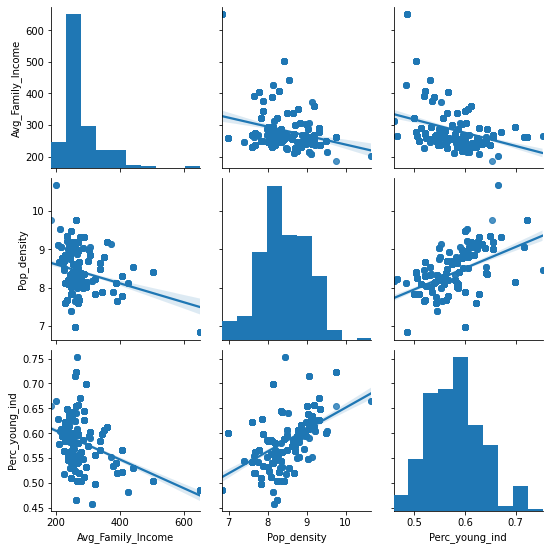

In [23]:
features = main_table[['Avg_Family_Income','Pop_density','Perc_young_ind']]
g = sns.pairplot(features,kind="reg")


## Ranking locations according to average family income, population density and percentage of young adults. 

###The best locations are the ones with low ranking scores (i.e., high average family income, population density and percentage of young adults). Locations near St Simon Catholic Elementary School, Suon Academy St Basil, The Great College School, and Pelmo Park Public School had the lowest ranking scores and are the best options to open the new branch of WD’s Office & School Supplies.






In [24]:
Avg_Family_Income=main_table['Avg_Family_Income'].unique()
Rank=np.linspace(len(Avg_Family_Income),1,num=len(Avg_Family_Income))

rank__Avg_Family_Income=[]
for i in range(0,main_table.shape[0]):
  temp_value=main_table['Avg_Family_Income'][i]
  comp=False
  cont=0
  while comp==False:
    if temp_value == Avg_Family_Income[cont]:
      comp = True
      rank__Avg_Family_Income.append(Rank[cont])
    cont += 1

main_table['rank__Avg_Family_Income']=rank__Avg_Family_Income

##############

Pop_density=main_table['Pop_density'].unique()
Rank=np.linspace(len(Pop_density),1,num=len(Pop_density))

rank_Pop_density=[]
for i in range(0,main_table.shape[0]):
  temp_value=main_table['Pop_density'][i]
  comp=False
  cont=0
  while comp==False:
    if temp_value == Pop_density[cont]:
      comp = True
      rank_Pop_density.append(Rank[cont])
    cont += 1
  
main_table['rank_Pop_density']=rank_Pop_density

################

Perc_young_ind=main_table['Perc_young_ind'].unique()
Rank=np.linspace(len(Perc_young_ind),1,num=len(Perc_young_ind))

rank_Perc_young_ind=[]
for i in range(0,main_table.shape[0]):
  temp_value=main_table['Perc_young_ind'][i]
  comp=False
  cont=0
  while comp==False:
    if temp_value == Perc_young_ind[cont]:
      comp = True
      rank_Perc_young_ind.append(Rank[cont])
    cont += 1
  
main_table['rank_Perc_young_ind']=rank_Perc_young_ind


main_table['Overall_rank']=main_table[['rank__Avg_Family_Income','rank_Pop_density','rank_Perc_young_ind']].sum(axis=1)

main_table.sort_values(['Overall_rank'],inplace=True)
main_table.head()


,_id,OBJECTID,GEO_ID,NAME,SCHOOL_LEVEL,SCHOOL_TYPE,BOARD_NAME,SOURCE_ADDRESS,SCHOOL_TYPE_DESC,ADDRESS_POINT_ID,ADDRESS_NUMBER,LINEAR_NAME_FULL,ADDRESS_FULL,POSTAL_CODE,MUNICIPALITY,CITY,PLACE_NAME,GENERAL_USE_CODE,CENTRELINE_ID,LO_NUM,LO_NUM_SUF,HI_NUM,HI_NUM_SUF,LINEAR_NAME_ID,X,Y,LATITUDE,LONGITUDE,geometry_x,Neighbourhood,Avg_Family_Income,Pop_density,Perc_young_ind,geometry_y,Pop_density_marker,Avg_Family_Income_marker,Perc_young_ind_marker,rank__Avg_Family_Income,rank_Pop_density,rank_Perc_young_ind,Overall_rank
741,8816,1082,565947,St Simon Catholic Elementary School,NaN,ES,Toronto Catholic District School Board,24 Strathburn Blvd,English Separate,565947,24,Strathburn Blvd,24 Strathburn Blvd,M9M 2K3,North York,Toronto,NaN,102001,445303,24,NaN,NaN,NaN,6808,302126.254,4841884.812,43.718909,-79.532987,"{""type"": ""Point"", ""coordinates"": [-79.53298734...",Pelmo Park-Humberlea,261.476576,7.638863,0.554728,"{""type"": ""Polygon"", ""coordinates"": [[[-79.5078...",yellow,yellow,yellow,1.0,1.0,1.0,3.0
756,8839,1105,553701,Suon Academy,NaN,PR,NaN,5 Queenslea Ave,Priv,553701,5,Queenslea Ave,5 Queenslea Ave,M9N 3X9,North York,Toronto,NaN,100001,446049,5,NaN,NaN,NaN,827,303842.609,4840958.025,43.710579,-79.511688,"{""type"": ""Point"", ""coordinates"": [-79.51168455...",Pelmo Park-Humberlea,261.476576,7.638863,0.554728,"{""type"": ""Polygon"", ""coordinates"": [[[-79.5078...",yellow,yellow,yellow,1.0,1.0,1.0,3.0
666,8705,971,14076257,St Basil The Great College School,NaN,ES,Toronto Catholic District School Board,20 Starview Lane,English Separate,14076257,20,Starview Lane,20 Starview Lane,M9M 3B2,North York,Toronto,St Basil-the-Great College School(Catholic Sec...,102004,10527859,20,NaN,NaN,NaN,11393,302089.301,4842802.393,43.727168,-79.533451,"{""type"": ""Point"", ""coordinates"": [-79.53345069...",Pelmo Park-Humberlea,261.476576,7.638863,0.554728,"{""type"": ""Polygon"", ""coordinates"": [[[-79.5078...",yellow,yellow,yellow,1.0,1.0,1.0,3.0
576,8569,835,519066,Pelmo Park Public School,NaN,EP,Toronto District School Board,180 Gary Dr,English Public,519066,180,Gary Dr,180 Gary Dr,M9N 2M1,North York,Toronto,Pelmo Park Public School,102001,445999,180,NaN,NaN,NaN,5666,303324.350,4841123.224,43.712065,-79.518119,"{""type"": ""Point"", ""coordinates"": [-79.51811616...",Pelmo Park-Humberlea,261.476576,7.638863,0.554728,"{""type"": ""Polygon"", ""coordinates"": [[[-79.5078...",yellow,yellow,yellow,1.0,1.0,1.0,3.0
790,8886,1152,1001687,Thistletown Collegiate Institute,NaN,EP,Toronto District School Board,20 Fordwich Cres,English Public,1001687,20,Fordwich Cres,20 Fordwich Cres,M9W 2T4,Etobicoke,Toronto,Thistletown Collegiate Institute,102002,907494,20,NaN,NaN,NaN,1624,299752.807,4842865.819,43.727735,-79.562456,"{""type"": ""Point"", ""coordinates"": [-79.56245264...",Rexdale-Kipling,255.372277,8.364042,0.531935,"{""type"": ""Polygon"", ""coordinates"": [[[-79.5551...",orange,yellow,yellow,2.0,2.0,2.0,6.0


## Plotting the locations according to their overall ranking. 

### Red points indicate regions with low ranking scores, orange points represent intermediate ranking scores, and yellow points are locations with high ranking scores. In these cases, the lower the ranking the better the location.    

In [25]:
address = 'Toronto, ON'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude


map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11,tiles='Stamen Toner')

main_table['Overall_rank_marker'] = pd.cut(main_table['Overall_rank'], bins=3, 
                              labels=['red', 'orange','yellow'])

for index, row in main_table.iterrows():
    folium.CircleMarker([row['LATITUDE'], row['LONGITUDE']],
                    radius=2,
                    color=row['Overall_rank_marker']).add_to(map_toronto)
map_toronto

/usr/local/lib/python3.6/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning
